# EDA and Models for Sentiment Analysis
This notebook contains some EDA done with the sentiment dataset, as well as the models used to classify the data into good and bad/neutral.

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import sys
from time import time

# Add custom functions path
sys.path.append('../Functions')

In [2]:
# Import data with custom function so the imported classes are balanced
from datasets import load_stratified_dataset
df = load_stratified_dataset(path='../Datasets/full_good_bad_dataset.csv', labels='label', samples_per_label=3000)

# Did it work?
df.label.value_counts()

Smallest sample size in dataset is 2854 samples!


1    2854
0    2853
Name: label, dtype: int64

## EDA
***
- label: 1 = good sentiment; 0 = neutral/bad sentiment
- source: the website or database from where articles were pulled or scraped
- text: the complete article text
- title: the news headline
- url: the original link to where an article was published
- text_lem: preprocessed article text
- url_short: extracted the domain name from the url
***

In [3]:
# Overview of the dataset
df.head()

,label,source,text,title,url,text_lem,url_short
0,1,webhose.io,"Baha Mar Ltd.\nNASSAU, Bahamas and WILMINGTON...",Baha Mar Files Chapter 11 Plan of Reorganization,NaN,baha mar ltd nassau bahamas wilmington del aug...,NaN
1,0,webhose.io,"MIDDLETOWN, Calif. (AP) - A new wildfire in No...",New wildfire in Northern California kills 1,NaN,middletown calif ap new wildfire northern cali...,NaN
2,0,JustBadNews,"Like the authorities in many other countries, ...",NHS rejects Apple-Google coronavirus app plan....,https://bbc.co.uk/news/technology-52441428,like authority country nhsx opt use wireless b...,bbc
3,0,webhose.io,Updated: 9:50 9:50 Death toll in Ukraine e...,Death toll in Ukraine excursion boat capsizing...,NaN,update 9:50 9:50 death toll ukraine excursion ...,NaN
4,1,good_news_network,Athletes will be able to use traditional Chine...,Chinese Medicine Allowed for Athletes at Olymp...,https://www.goodnewsnetwork.org/chinese-medici...,athlete able use traditional chinese medicine ...,goodnewsnetwork


#### Sources
Let's look at the distribution among the sources we have.

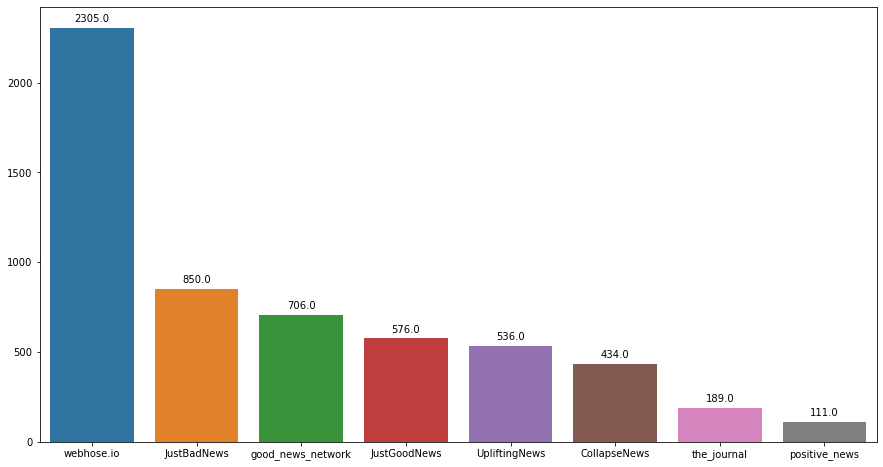

In [4]:
# Plot the source distribution
fig, ax = plt.subplots(figsize= (15,8))
ax = sns.barplot(x=df.source.value_counts().index, y=df.source.value_counts().values)
for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

***
Most of the data comes from the webhose dataset, which makes sense since it is the biggest collection of labeled articles we have.
Furthermore it contains the biggest part of the neutral/bad articles, because it was a lot easier to scrape good news from specific sites. Let's see if this holds true.
***

In [5]:
df.query('label == 0').source.value_counts()

webhose.io      1569
JustBadNews      850
CollapseNews     434
Name: source, dtype: int64

In [6]:
df.query('label == 1').source.value_counts()

webhose.io           736
good_news_network    706
JustGoodNews         576
UpliftingNews        536
the_journal          189
positive_news        111
Name: source, dtype: int64

***
More than half of the articles from webhose are neutral/bad. So this balances out the data in general.
***

#### Original News Sites
Let's look at the different source domains in this dataset (news site where the article was first posted to).

In [7]:
# Count unknown article source and drop them
url_list = df.url_short
print(f'The source domain is unknown for {df.url_short.isnull().sum()} articles')
url_list = url_list.dropna();

The source domain is unknown for 2305 articles


In [8]:
# Count the number of times the domain appears
values, counts = np.unique(url_list, return_counts=True)
df_url = {'url' : values, 'count' : counts}
df_url = pd.DataFrame(data=df_url)

# Sort by counts
df_url_sorted = df_url.sort_values('count', ascending=False)

# Print result
print('====Top 10 Source domains====')
print('')
print(df_url.sort_values('count', ascending=False)[0:10])
print('')
print('-------------------------------------------------------')
print(f'There are at least {df_url.url.nunique()} unique domains in this dataset')
print('-------------------------------------------------------')

====Top 10 Source domains====

                 url  count
223  goodnewsnetwork    706
49               bbc    206
565       thejournal    169
558      theguardian    161
109              cnn    113
439         positive    111
464          reuters    105
256      independent     89
371          nbcnews     39
405          nytimes     39

-------------------------------------------------------
There are at least 684 unique domains in this dataset
-------------------------------------------------------


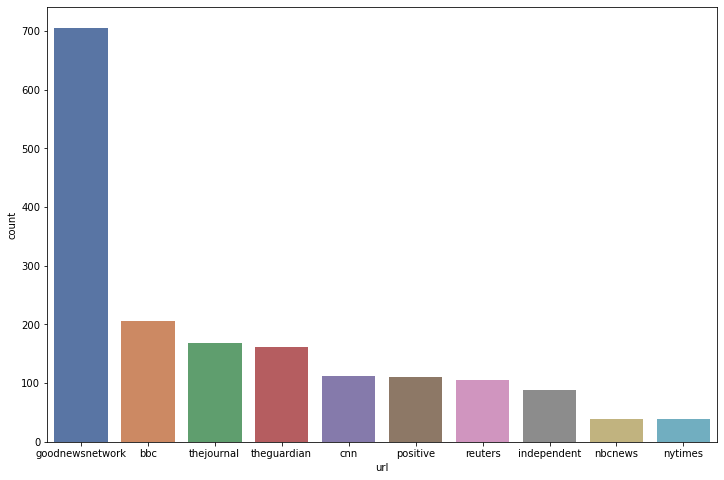

In [9]:
# Show top 10 domains
dims = (12, 8)
fig, ax = plt.subplots(figsize=dims)
ax = sns.barplot(x="url", y="count", data=df_url_sorted[0:10], palette='deep')

***
'goodnewsnetwork' is one of the scraped websites for positive news. In contrast to other similar sites, they write all of their articles and don't link to external sources. 
Thus it was expected that they would be one of the most frequent sites to find in our dataset.
'Positive' and 'thejournal' are also scraped sites for positive news, where they write some articles themselves.
***

In [10]:
# Drop scraped sites that contain their own articles
df_url_sorted = df_url_sorted.drop(df_url_sorted[df_url_sorted.url == 'goodnewsnetwork'].index)
df_url_sorted = df_url_sorted.drop(df_url_sorted[df_url_sorted.url == 'positive'].index)
df_url_sorted = df_url_sorted.drop(df_url_sorted[df_url_sorted.url == 'thejournal'].index)

The top 10 domains contribute at least 860 articles to the dataset


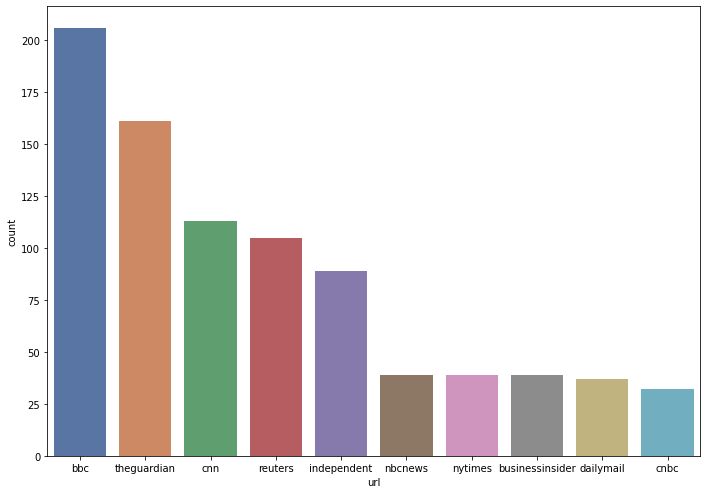

In [11]:
# Show top 10 again
dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
ax = sns.barplot(x="url", y="count", data=df_url_sorted[0:10], palette='deep')
print(f'The top 10 domains contribute at least {df_url_sorted["count"][0:10].sum()} articles to the dataset')

***
Without the specific sites, we can find the biggest news sites in the world contribute a lot of articles to the dataset.
***

#### Word influence on good and neutral/bad news
Next up we will analyse the word distribution among the two classes.

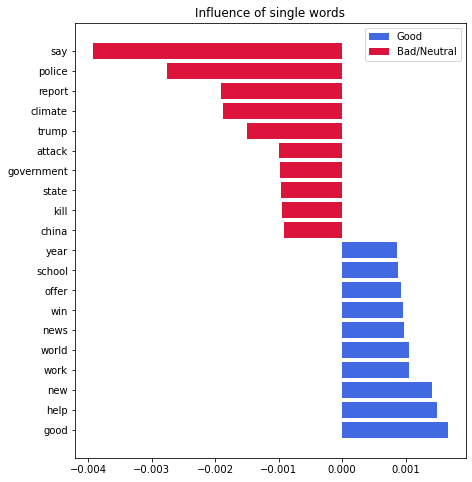

In [12]:
# Import libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize words by their number of appearance
vect = CountVectorizer()
X = vect.fit_transform(df.text_lem)
words = vect.get_feature_names()

# Define label
y = df['label'].values

# Remove alpha to prevent bias
clf = MultinomialNB(alpha=1.e-10)
clf.fit(X,y)

# Create Dataframe for probability
likelihood_df = pd.DataFrame(clf.feature_log_prob_.transpose(),columns=['negative', 'positive'], index=words)
likelihood_df['Influence'] = likelihood_df.eval('(exp(positive) - exp(negative))')
top_10 = likelihood_df['Influence'].sort_values(ascending=False)[:10]

# Double-sorting here so that the graph will look nicer
bottom_10 = likelihood_df['Influence'].sort_values()[:10].sort_values(ascending=False)
top_and_bottom = pd.concat([top_10,bottom_10])

# Plot
x = range(10)
fig = plt.figure(figsize=(7,8))
ax = plt.subplot(111)
ax.barh(top_10.index, top_10, color='royalblue')
ax.barh(bottom_10.index, bottom_10, color='crimson');
ax.set_title('Influence of single words');
ax.legend(['Good', 'Bad/Neutral']);

***
The influence of neutral/bad words seems to be greater than that of good words. Also the word 'say' seems to appear a lot more in neutral/bad labeled articles than in good ones, which could maybe be explained by newstype (for example political, which includes a lot of citations). Sadly this dataset doesn't inclued news categories at this point, so a final verdict is difficult.



***

## Models
We will try out different models and combine appropriate ones into a VotingClassifier with soft voting. Why soft voting? So we can manipulate the threshold for news being positive. A very high probability should also correlate with the news being very positive.

In [13]:
# Importing the auxiliary and preprocessing libraries 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# Import Models
import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Set random_state
random_state = 69

In [14]:
# Best parameters from Grid- or RandomizedSearch
def best_parameters(model_name):
    print('---------------')
    print('Best parameters')
    print('---------------')
    for pair in model_name.best_params_.items():
        print(f'{pair[0].capitalize()} : {pair[1]}')

In [15]:
# Create models
models = []
models.append(("LogReg", LogisticRegression(n_jobs=-1, random_state=random_state)))  
models.append(("SGD_log", SGDClassifier(random_state=random_state, n_jobs=-1, loss='log')))
models.append(("NaiveBayes", MultinomialNB()))
models.append(("XGB", XGBClassifier(n_jobs=-1, random_state=random_state)))
models.append(("RandomForest", RandomForestClassifier(n_jobs=-1, random_state=random_state)))
models.append(("ExtraTrees", ExtraTreesClassifier(n_jobs=-1, random_state=random_state)))
models.append(("Ridge", RidgeClassifier(random_state=random_state)))
models.append(("BaggingRidge", BaggingClassifier(n_jobs=-1, random_state=random_state)))
models.append(("LinearSVC", LinearSVC(random_state=random_state)))
models.append(("SGD_hinge", SGDClassifier(random_state=random_state, n_jobs=-1, loss='hinge')))

In [16]:
# Split into train, test and validation dataframe
df_train, df_test = train_test_split(df, test_size=.2, random_state = random_state)
df_train, df_val = train_test_split(df_train, test_size=.2, random_state = random_state)

# Define train test and validation sets
X_train, y_train  = df_train['text_lem'], df_train['label']
X_test, y_test = df_test['text_lem'], df_test['label']
X_val, y_val = df_val['text_lem'], df_val['label']

In [17]:
# Get values from the group and categories
xaxis_label = np.sort(df_train.source.unique())
yaxis_train = df_train.source.value_counts().sort_index()
yaxis_test = df_test.source.value_counts().sort_index()
yaxis_val = df_val.source.value_counts().sort_index()

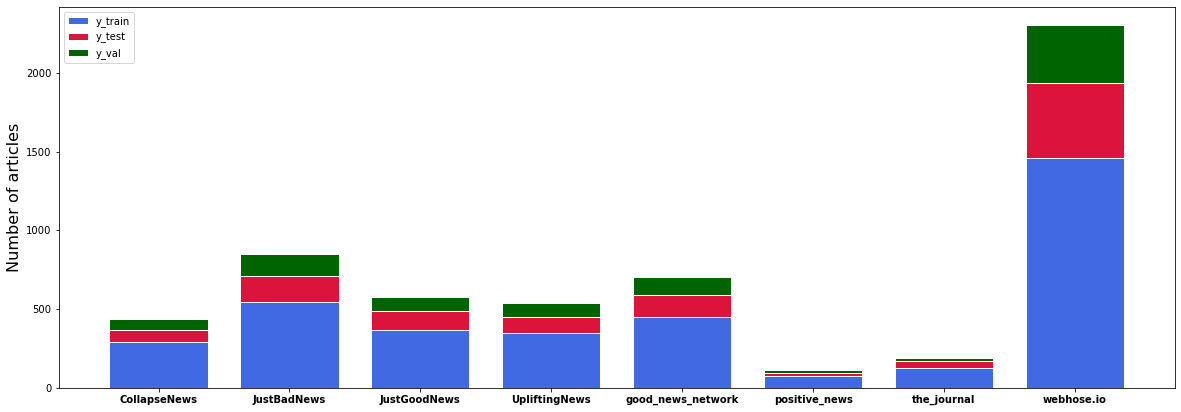

In [18]:
# Plot the distribution of sources in our datasets
r = range(len(yaxis_train))
barWidth = .75

# Plot bars
plt.figure(figsize=(20,7))
ax1 = plt.bar(r, yaxis_train, color='royalblue', edgecolor='white', width=barWidth, label="y_train")
ax2 = plt.bar(r, yaxis_test, bottom=np.array(yaxis_train), color='crimson', edgecolor='white', width=barWidth, label='y_test')
ax3 = plt.bar(r, yaxis_val, bottom=np.array(yaxis_train)+np.array(yaxis_test), color='darkgreen', edgecolor='white', width=barWidth, label='y_val')
plt.legend()
# Custom X axis
plt.xticks(r, xaxis_label, fontweight='bold')
plt.ylabel("Number of articles", Fontsize=16)
plt.show()

In [19]:
# Sample weights for training since sources are very imbalanced
source_weight = 1/df_train.source.value_counts() * df_train.source.value_counts()[0]
sample_weight = [source_weight[i] for i in df_train.source]
source_weight

webhose.io            1.000000
JustBadNews           2.683824
good_news_network     3.273543
JustGoodNews          3.967391
UpliftingNews         4.195402
CollapseNews          5.087108
the_journal          11.869919
positive_news        19.210526
Name: source, dtype: float64

In [20]:
# Vectorize the data
tfidf = TfidfVectorizer(stop_words='english')

# Fit the transformer
tfidf_fit = tfidf.fit(X_train)

# Transform all splits
X_train_tfidf = tfidf_fit.transform(X_train)
X_test_tfidf = tfidf_fit.transform(X_test)
X_val_tfidf = tfidf_fit.transform(X_val)

# Save the fitted transformer
pickle.dump(tfidf_fit, open("tfidf_sentiment.pickle", "wb"))

In [21]:
# Print shapes of the splits
print(f'Shape train: {X_train.shape[0]} rows')
print(f'Shape test: {X_test.shape[0]} rows')
print(f'Shape val: {X_val.shape[0]} rows')

Shape train: 3652 rows
Shape test: 1142 rows
Shape val: 913 rows


In [22]:
# Run models
# Dataframe for results
model_results = pd.DataFrame(columns=['name', 'train', 'test', 'runtime'])

# Run, save and display results
for name, model  in models:
    
    # Starttime
    start = time()
    
    # Fit the model
    cv_results = model.fit(X_train_tfidf, y_train, sample_weight=sample_weight)
    
    # Score the model on train and test
    train_res = (model.score(X_train_tfidf, y_train)*100).round(2)
    test_res = (model.score(X_test_tfidf, y_test)*100).round(2)

    # Endtime
    end = time()
    
    # Runtime of each algorithm
    runtime = end-start
    
    # Save results
    results_df = pd.DataFrame([[name, train_res, test_res, runtime]], columns=['name', 'train', 'test', 'runtime'])
    model_results = model_results.append(results_df)
    
# Show results
model_results.set_index(pd.Index(list(range(0, model_results.shape[0]))), inplace=True)
model_results

,name,train,test,runtime
0,LogReg,94.61,83.19,1.330056
1,SGD_log,98.63,84.76,0.025034
2,NaiveBayes,85.76,73.29,0.013200
3,XGB,99.32,83.63,15.103220
4,RandomForest,99.86,84.24,1.990409
5,ExtraTrees,99.86,83.10,3.375754
6,Ridge,98.36,79.33,0.082767
7,BaggingRidge,98.82,77.58,10.703272
8,LinearSVC,99.78,86.08,0.359142
9,SGD_hinge,99.78,85.38,0.034253


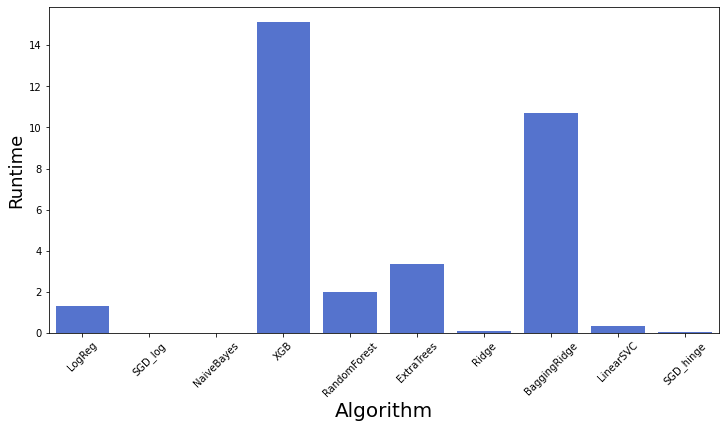

In [23]:
# Plot the runtime
fig = plt.figure(figsize=(12,6))
ax = sns.barplot(x="name", y="runtime", data=model_results, color='royalblue')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);
ax.set_xlabel("Algorithm", fontsize=20);
ax.set_ylabel("Runtime", fontsize=18)
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True

***
XGB and BaggingRidge are quite slow in comparis to the other models.
***

### Optimization

Let's use the best models and try to optimize them for the VotingClassifier later.

In [24]:
# Sort models based on test results
model_results.sort_values(by=['test'], ascending=False)

,name,train,test,runtime
8,LinearSVC,99.78,86.08,0.359142
9,SGD_hinge,99.78,85.38,0.034253
1,SGD_log,98.63,84.76,0.025034
4,RandomForest,99.86,84.24,1.990409
3,XGB,99.32,83.63,15.103220
0,LogReg,94.61,83.19,1.330056
5,ExtraTrees,99.86,83.10,3.375754
6,Ridge,98.36,79.33,0.082767
7,BaggingRidge,98.82,77.58,10.703272
2,NaiveBayes,85.76,73.29,0.013200


***
We will tune the SVC just to see how well it could perfom. We can't use it for the VotingClassifier because SVMs don't compute a probability. Since we want the VotingClassifier to give us a probability for each case (so we can adjust the threshold), we can't implement the SVC.

We will use LogReg, because unlike the SGD_Log it is not overfitting already. Furthermore we use the ExtraTressClassifier, XGB and NaiveBayes.
***

#### Linear SupportVectorClassifier
The above results already show that the SVC is overfitting on the train set. This needs to be fixed for a better generalization later on.

In [25]:
# Try different C values 
C_sv = np.arange(0.025, 0.4, 0.025)
sv_results = pd.DataFrame(columns=['C', 'train', 'test', 'runtime'])
for c in C_sv:
    start = time()
    sv = LinearSVC(random_state=random_state, C=c)
    sv.fit(X_train_tfidf, y_train, sample_weight=sample_weight)
    end = time()
    runtime = end-start
    
    train_res = (sv.score(X_train_tfidf, y_train)*100).round(2)
    test_res = (sv.score(X_test_tfidf, y_test)*100).round(2)
    
    # Save results
    results_df = pd.DataFrame([[c, train_res, test_res, runtime]], columns=['C', 'train', 'test', 'runtime'])
    sv_results = sv_results.append(results_df)
    
sv_results.set_index(pd.Index(list(range(0, sv_results.shape[0]))), inplace=True)

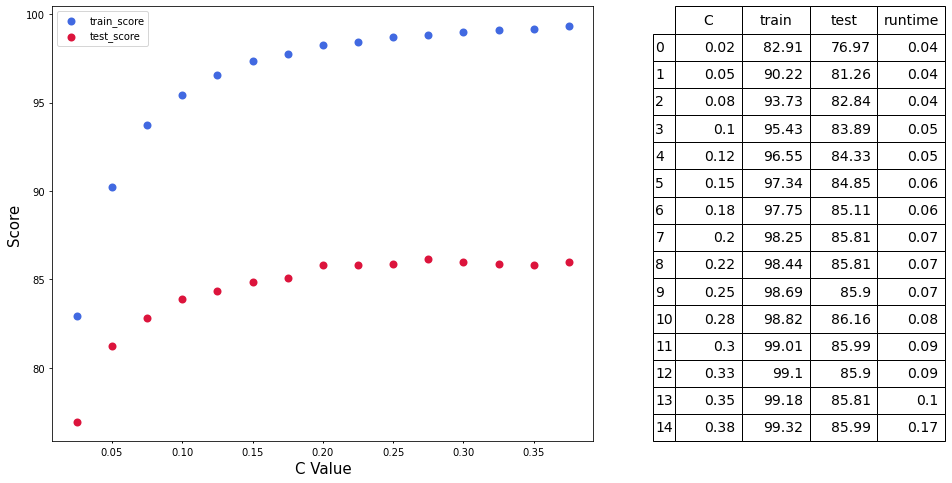

In [26]:
# Plot results
fig = plt.figure(constrained_layout=False, figsize=(16,8))
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[2, 1])

ax1 = fig.add_subplot(spec[0])
ax1.scatter(sv_results.C, sv_results.train, label='train_score', color='royalblue', linewidth=2)
ax1.scatter(sv_results.C, sv_results.test, label='test_score', color='crimson', linewidth=2)
plt.xlabel('C Value', Fontsize=15)
plt.ylabel('Score', Fontsize=15)
plt.legend();

ax2 = fig.add_subplot(spec[1])
font_size=14
bbox=[0, 0, 1, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText = sv_results.values.round(2), rowLabels = sv_results.index, bbox=bbox, colLabels=sv_results.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

***
We could use SVC as a standalone algorithm if we didn't want to implement a treshold. It would perform very well.
***

#### Logistic Regression

The default algorithm is already quite good. We can take a look at what happens when we introduce a few different C-Scores.

In [28]:
# Try different C values
C_lr = np.arange(0.1, 2, 0.1)
lr_results = pd.DataFrame(columns=['C', 'train', 'test', 'runtime'])
for c in C_lr:
    start = time()
    lr = LogisticRegression(random_state=random_state, C=c)
    lr.fit(X_train_tfidf, y_train, sample_weight=sample_weight)
    end = time()
    runtime = end-start
    
    train_res = (lr.score(X_train_tfidf, y_train)*100).round(2)
    test_res = (lr.score(X_test_tfidf, y_test)*100).round(2)
    
    # Save results
    results_df = pd.DataFrame([[c, train_res, test_res, runtime]], columns=['C', 'train', 'test', 'runtime'])
    lr_results = lr_results.append(results_df)
    
lr_results.set_index(pd.Index(list(range(0, lr_results.shape[0]))), inplace=True)

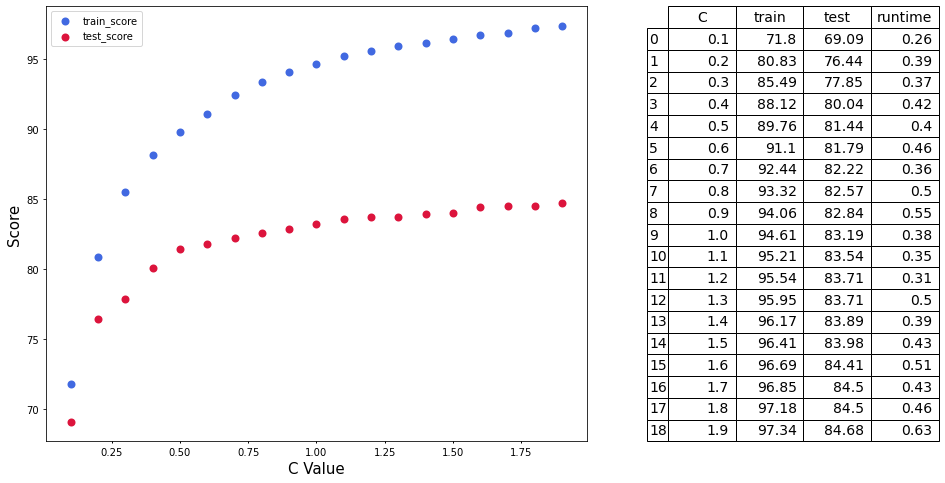

In [29]:
# Plot results
fig = plt.figure(constrained_layout=False, figsize=(16,8))
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[2, 1])

ax1 = fig.add_subplot(spec[0])
ax1.scatter(lr_results.C, lr_results.train, label='train_score', color='royalblue', linewidth=2)
ax1.scatter(lr_results.C, lr_results.test, label='test_score', color='crimson', linewidth=2)
plt.xlabel('C Value', Fontsize=15)
plt.ylabel('Score', Fontsize=15)
plt.legend();

ax2 = fig.add_subplot(spec[1])
font_size=14
bbox=[0, 0, 1, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText = lr_results.values.round(2), rowLabels = lr_results.index, bbox=bbox, colLabels=lr_results.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

In [63]:
# Create best model and fit
lr_best = LogisticRegression(random_state=random_state, C=1.2)
lr_best.fit(X_train_tfidf, y_train, sample_weight=sample_weight)
print(f'Accuracy trainset : {(lr_best.score(X_train_tfidf, y_train)*100).round(2)}')
print(f'Accuracy testset : {(lr_best.score(X_test_tfidf, y_test)*100).round(2)}')

Accuracy trainset : 95.54
Accuracy testset : 83.71


#### Extra-trees classifier

In [31]:
# Define basemodel
et = ExtraTreesClassifier(n_jobs=-1, random_state=random_state, max_depth=67, min_samples_split=5, bootstrap=False,
                         criterion='gini', min_samples_leaf=1)
et.fit(X_train_tfidf, y_train, sample_weight=sample_weight)
print(f'Accuracy trainset : {(et.score(X_train_tfidf, y_train)*100).round(2)}')
print(f'Accuracy testset : {(et.score(X_test_tfidf, y_test)*100).round(2)}')

Accuracy trainset : 94.19
Accuracy testset : 78.9


In [32]:
# Define parameters
params_et = {'max_depth' : np.linspace(10, 200, num = 11).tolist() + [None],
            'min_samples_split' : [5, 10, 15, 20, 25, 30, 50],
            'min_samples_leaf' : [1,2,3,4,5],
            'bootstrap' : [True, False],
            'max_leaf_nodes' : [50, 100, 150, 200, 500],
            'criterion' : ['gini', 'entropy']
            }

# Run GridSearch
et_search = RandomizedSearchCV(et, params_et, cv=3, n_jobs=-1, verbose=1, n_iter = 100, random_state=random_state)
et_search.fit(X_train_tfidf, y_train, sample_weight=sample_weight)

# Print the best parameters
best_parameters(et_search)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.5min finished


---------------
Best parameters
---------------
Min_samples_split : 15
Min_samples_leaf : 1
Max_leaf_nodes : 500
Max_depth : 162.0
Criterion : entropy
Bootstrap : True


In [33]:
# Get best model
et_best = ExtraTreesClassifier(n_jobs=-1, random_state=random_state, max_depth=110, min_samples_split=15, bootstrap=True,
                         criterion='entropy', min_samples_leaf=1, max_leaf_nodes=500)
# Fit on the data
et_best.fit(X_train_tfidf, y_train, sample_weight=sample_weight)

# Print results
print(f"Accuracy for train set : {(et_best.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(et_best.score(X_test_tfidf, y_test)*100).round(2)}%")

Accuracy for train set : 95.51%
Accuracy for test set : 82.31%


#### XGBClassifier

In [59]:
# Define basemodel
xgb = XGBClassifier(n_jobs=-1, random_state=random_state, learning_rate=0.1)
xgb.fit(X_train_tfidf, y_train, sample_weight=sample_weight)
print(f'Accuracy trainset : {(xgb.score(X_train_tfidf, y_train)*100).round(2)}')
print(f'Accuracy testset : {(xgb.score(X_test_tfidf, y_test)*100).round(2)}')

Accuracy trainset : 94.61
Accuracy testset : 81.44


#### Voting Classifier

In [65]:
vc = VotingClassifier(estimators=[('lr', lr_best), ('et', et_best), ('xgb', xgb)], voting='soft')
vc.fit(X_train_tfidf, y_train, sample_weight=sample_weight);
pickle.dump(vc, open("vc_sentiment.pickle", "wb"))

In [70]:
# Save predictions for each set and probability for validation set
y_pred_train = vc.predict(X_train_tfidf)
y_pred_test = vc.predict(X_test_tfidf)
y_pred_val = vc.predict(X_val_tfidf)
y_pred_val_proba = vc.predict_proba(X_val_tfidf) 

# Print results
print(f"Accuracy for train set : {(vc.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(vc.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(vc.score(X_val_tfidf, y_val)*100).round(2)}%")

Accuracy for train set : 95.92%
Accuracy for test set : 84.06%
Accuracy for val set: 84.45%


In [77]:
# Play with different thresholds for the prediction
y_proba_val = (y_pred_val_proba[:,1] > 0.65) *1
print(confusion_matrix(y_val, y_proba_val))
print(classification_report(y_test_XX, y_proba_val))

[[415  46]
 [ 94 358]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       509
           1       1.00      1.00      1.00       404

    accuracy                           1.00       913
   macro avg       1.00      1.00      1.00       913
weighted avg       1.00      1.00      1.00       913



***
The reason we want to use a VotingClassifier with soft voting is, that it enables us to set a threshold for how positive a article must be to be chosen by our algorithm. Maybe we only want really really positive news later on. This gives us the possiblity to do so.
***

### Incorrect predictions
Let's find out where our model is wrong so we can analyse the problems and maybe fix them in later stages of the project.

In [73]:
# Create a list of all incorrectly predicted articles in the validation set
incorrect_pred = []
correct_pred = []
idx = 0
for vect, prediction, label in zip(X_val_tfidf, y_pred_val, y_val):
    if prediction != label:
        incorrect_pred.append(X_val.index[idx])
    else:
        correct_pred.append(X_val.index[idx])
    idx += 1

In [74]:
# Create dataframes for wrong and correct predictions
df_incorrect_predictions = df[df.index.isin(incorrect_pred)]
df_correct_predictions = df[df.index.isin(correct_pred)]

In [75]:
# Filter out the source, where our model is wrong and right
source_series = pd.Series(data=0, index=df.source.value_counts().index).sort_index()
source_incorrect = df_incorrect_predictions.source.value_counts().sort_index()
source_incorrect = source_series.combine(source_incorrect,max)
source_correct = df_correct_predictions.source.value_counts().sort_index()
source_correct = source_series.combine(source_correct,max)
source_all = (source_incorrect + source_correct).sort_index()

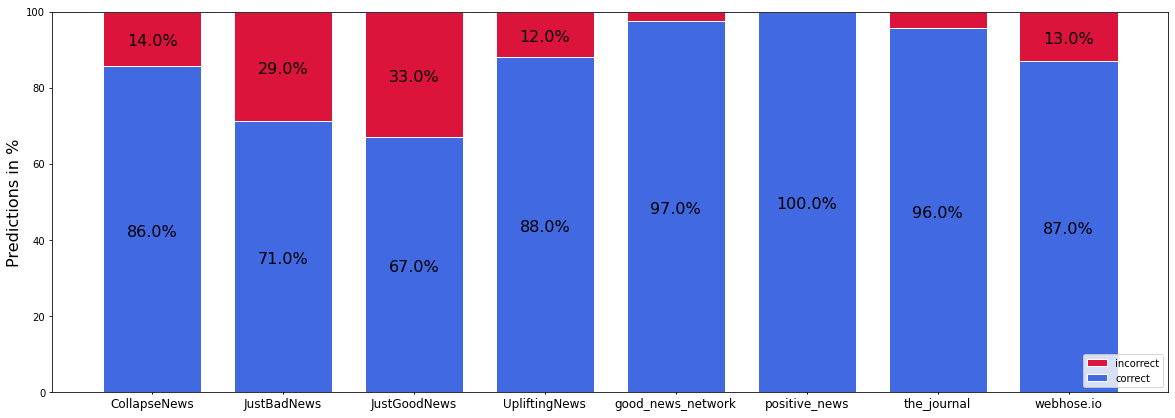

In [76]:
# Plot predictions for different sources in percent

# Get prediction values
x = source_all.index
y_incorrect = source_incorrect.values
y_correct = source_correct.values
total = y_incorrect + y_correct
proportion_incorrect = np.true_divide(y_incorrect, total) * 100
proportion_correct = np.true_divide(y_correct, total) * 100
    
# Chose colors
colors = ['crimson', 'royalblue']

# The position of the bars on the x-axis
r = range(len(x))
barWidth = 0.75

# Plot
fig, ax = plt.subplots(figsize=(20,7))
rects1 = ax.bar(r, proportion_incorrect, bottom=proportion_correct, color=colors[0], edgecolor='white', width=barWidth, label="incorrect")
rects2 = ax.bar(r, proportion_correct, color=colors[1], edgecolor='white', width=barWidth, label='correct')

height = []
for rect in rects2:
    height.append(rect.get_height())

i = 0
for rect in rects2:
    ax.annotate(str(height[i].round()) + '%',
                xy=(rect.get_x() + rect.get_width() / 2, height[i] / 2),
                xytext=(0, -10),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                Fontsize=16)
    ax.annotate((str(100 - height[i].round()) + '%') if height[i] < 95 else ' ',
                xy=(rect.get_x() + rect.get_width() / 2, height[i] + (100 - height[i])/2),
                xytext=(0, -10), 
                textcoords="offset points",
                ha='center', va='bottom',
                Fontsize=16)
    i += 1
    
plt.legend(loc=4)
plt.xticks(r, x, Fontsize=12)
plt.ylabel("Predictions in %", Fontsize=16)
plt.show()

***
It seems to be rather easy for our model to find all the good news from specific websites, but harder to correctly ifdentify them from mix sources (JustGoodNews).
The problem here is that our model has specific trouble with the two sources which are themselves created by a good/bad news bot from reddit, which could mean our algorithm is worse than the bot or it disagrees with the bot and might actually be right in some cases.

Ultimately the problem lies within the structure of our dataset, because we can't be completely sure about the labeling of the data, besides the "only good news sites". 
These problems will persist until a well labeled dataset can be used.

A few examples of different problems can be seen below
***

In [147]:
# Clearly good news that are already labeled as bad but recognized as good by our model
pd.set_option('display.max_colwidth', -1)
print(df_incorrect_predictions.iloc[1][['title', 'text', 'label', 'source']])

title     The end of plastic? New plant-based bottles will degrade in a year                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [140]:
# Data where  only a fragment of the news article was scraped properly
print(df_incorrect_predictions.iloc[0][['title','text', 'label', 'source']])
print('--------------------')
print('--------------------')
print(df_incorrect_predictions.iloc[3][['title','text', 'label', 'source']])

title     Joyce Echaquan: Outcry in Canada over treatment of dying indigenous woman. A nurse is sacked after Joyce Echaquan filmed herself in hospital apparently being insulted by staff.                
text      A member of staff can be heard saying to her, in French: "You're stupid as hell." Another says Ms Echaquan had made bad choices in life and asks what her children would think of her behaviour.
label     0                                                                                                                                                                                               
source    JustBadNews                                                                                                                                                                                     
Name: 229, dtype: object
--------------------
--------------------
title     Amazon worker loses engagement ring in customer's parcel. Jasmine Paget is asking customers to check their deli

In [145]:
# Good news labeled as bad and missing text
print(df_incorrect_predictions.iloc[45][['title','text', 'label', 'source']])

title     Philippine police raid illegal hospital for Chinese virus patients. It was secretly treating Chinese nationals suspected of being infected with the coronavirus, who "may still be walking around in public possibly infecting other people".
text      Police teams inspect a seven-bed hospital during a raid at a villa, which was illegally turned into a medical facility in Clark Freeport and Special Economic Zone, northwest of Manila. Photo: AP                                           
label     0                                                                                                                                                                                                                                            
source    JustBadNews                                                                                                                                                                                                                                  
Name: 16

## Summary
- Basic data analysis was performed with the dataset, which showed, that a multitude of factors could influence our machine learning models (e.g. distribution of sources and what kind of news the mostly contain)
- A multitude of models was tested
- In the end we decided to use a VotingClassifier combining linear regression, extra trees classification and xgboost classification
- A soft voting was used to give the possibility of adjusting a threshold for how positive news have to be
- The analysis of wrongly classified articles showed problems especially with the data itself and not our models or the preprocessing

## Future Work
- Data cleaning (e.g. remove data that only includes fragments of the original text)
- Properly labeled dataset (very difficult)
- More/better tuning of models
- More research in preprocessing (vectorizer methods, tokenization, stop words etc.)
- More research in neural networks